# Linear Optimizer of the fitpass classes

@roman_avj

21 08 2023

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Point
from shapely.ops import cascaded_union
import fiona

import pulp as plp

# Part 0: Read & Wrangle Data


In [26]:
# read raw data
df_fitpass_r = pd.read_parquet('../data/scrapped_fitpass_cdmx.parquet')

# look at the data
df_fitpass_r.head()

,gym_id,gym_name,pro_status,virtual_status,class_minutes,notes,latitude,longitude,address,barre,...,gym,hiit,mma,pilates,pool,running,sports,virtual_class,wellness,yoga
0,3913,21159 Fit Movement,0,0,45,Centro de entrenamiento Funcional en HIIT. Som...,19.409432,-99.162129,"Av. Monterrey 271, esquina calle aguascalientes",0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4356,321 Move!,0,0,None,Movimiento y espacio virtual y presencial de F...,19.359657,-99.202687,"Pasaje Las Águilas, Calzada de las Águilas 321...",1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3529,360Cycle Virtual,0,1,None,En 360CYCLE creemos que para obtener resultado...,21.118018,-101.656584,Blvd. Adolfo López Mateos,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5576,3 Are Legend,0,0,None,Entrenamiento Funcional y box.,19.539159,-99.182145,Jesus Reyes Heroles 112,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3735,40º Grados Bikram Yoga,0,0,None,Estudio de Bikram Yoga y más en Zona Esmeralda,19.552389,-99.270923,Av. Adolfo Ruiz Cortines 247,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 0.1: wrangle data 

### 0.1.1 generate fictional ranking data




min: 1.388739114573078, max: 4.97549881470397


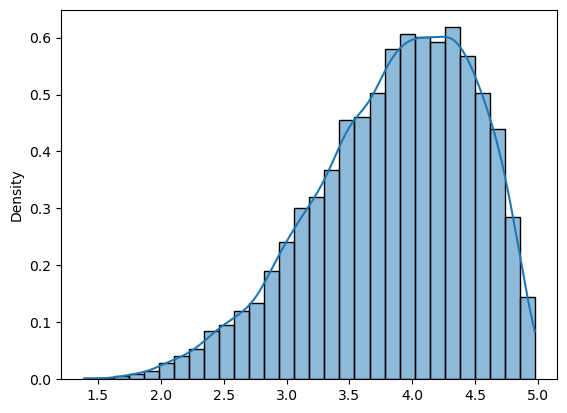

In [27]:
# fix random generator
rng = np.random.RandomState(8)

# generate 6*beta(5, 2) - 1 (rankings)
rnd_beta = 4*rng.beta(5, 2, size=10000) + 1

# plot beta distribution
sns.histplot(rnd_beta, stat='density', bins=30, kde=True)

# get range
print(f"min: {rnd_beta.min()}, max: {rnd_beta.max()}")

In [29]:
# generate fake rankings
df_fitpass_r["ranking"] = rng.beta(5, 2, size=df_fitpass_r.shape[0])

### 0.1.2: from EPSG:4326 to EPSG:6372


In [30]:
# change lon and lat dtypes from str to float
df_fitpass_r['longitude'] = df_fitpass_r['longitude'].astype(float)
df_fitpass_r['latitude'] = df_fitpass_r['latitude'].astype(float)

# pass the df to geopandas using the 'longitude' and 'latitude' columns to create a GeoDataFrame
gdf_fitpass_r = gpd.GeoDataFrame(
    df_fitpass_r, 
    geometry=gpd.points_from_xy(df_fitpass_r.longitude, df_fitpass_r.latitude),
      crs="EPSG:4326"
    )

something wierd is happening with the coords (was the installation of geopandas)

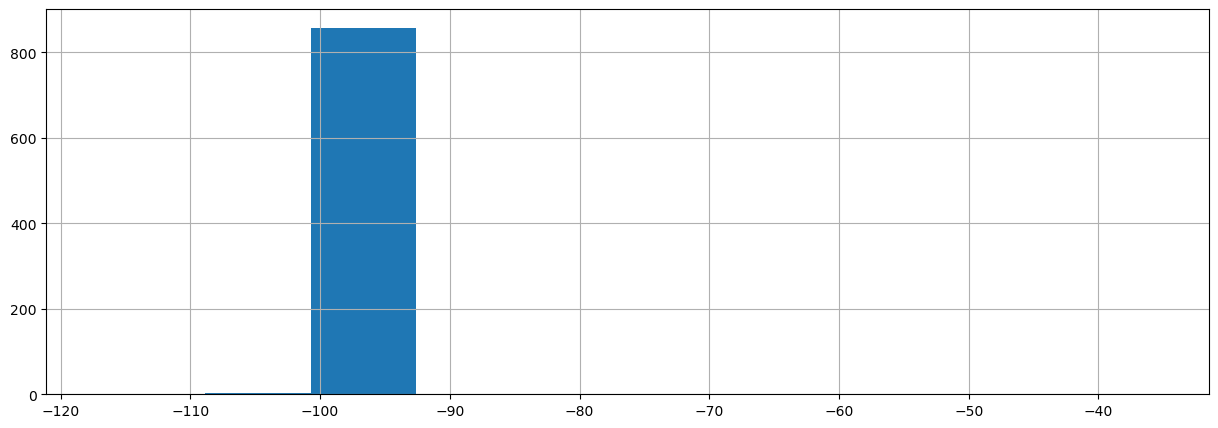

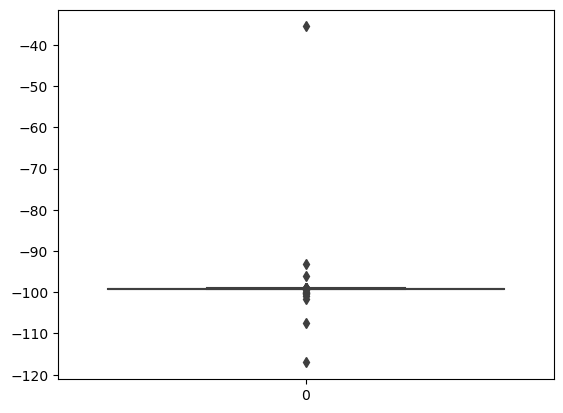

In [31]:
df_fitpass_r.longitude.describe()
df_fitpass_r.longitude.hist(bins=10, figsize=(15, 5))
plt.show()
sns.boxplot(df_fitpass_r.longitude)
plt.show()

In [32]:
df_fitpass_r.latitude.describe()

count    863.000000
mean      19.505291
std        1.701821
min       16.349820
25%       19.366204
50%       19.410814
75%       19.435136
max       66.358464
Name: latitude, dtype: float64

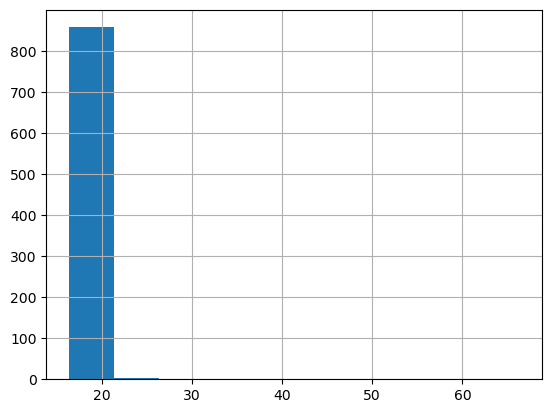

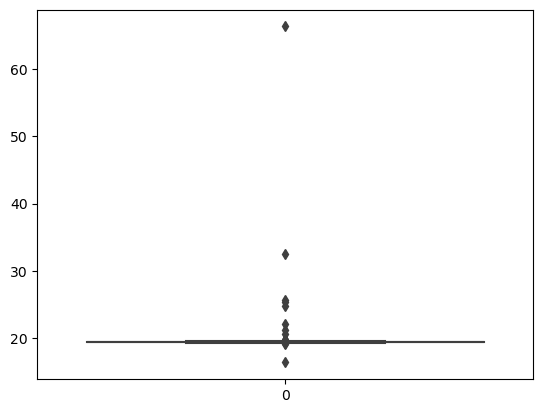

In [33]:
df_fitpass_r.latitude.hist(bins=10)
plt.show()
sns.boxplot(df_fitpass_r.latitude)
plt.show()

In [34]:
df_fitpass_r.latitude.describe()

count    863.000000
mean      19.505291
std        1.701821
min       16.349820
25%       19.366204
50%       19.410814
75%       19.435136
max       66.358464
Name: latitude, dtype: float64

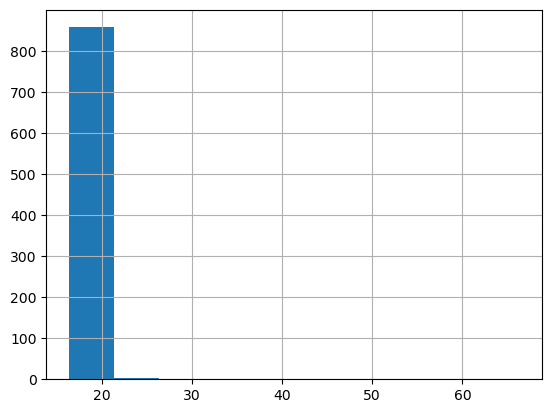

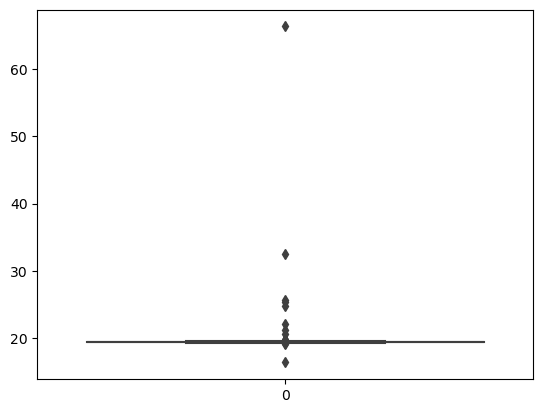

In [35]:
df_fitpass_r.latitude.hist(bins=10)
plt.show()
sns.boxplot(df_fitpass_r.latitude)
plt.show()

In [36]:
# plot points using folium
# initial possition of the map
m = folium.Map(location=[19.452519, -99.162381], tiles='cartodbpositron', zoom_start=12)

# add points to the map
for i, row in gdf_fitpass_r.iterrows():
    folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            tooltip=row['gym_name'],
            icon=folium.Icon(
                color="red",
                icon_color="black",
                weight=1,
                fill_opacity="black"
            )
        ).add_to(m)

# plot
m


what is happening is that i scraped info also from other states, therefore i need to filter the data to only include the state of interest

#### 0.1.3 use the shapes of all the blocks in mexico city

In [37]:
# read a geojson file containing the geometries of the blocks of the city
gdf_colonias = gpd.read_file('../data/colonias-cdmx-.json')
gdf_colonias


,ENT,CVEDT,NOMDT,DTTOLOC,CVEUT,NOMUT,ID,geometry
0,9,2,AZCAPOTZALCO,05,02-001,AGUILERA,1,"POLYGON ((-99.15901 19.47374, -99.15882 19.473..."
1,9,2,AZCAPOTZALCO,05,02-002,ALDANA,2,"POLYGON ((-99.14858 19.47156, -99.14863 19.471..."
2,9,2,AZCAPOTZALCO,05,02-005,ANGEL ZIMBRON,3,"POLYGON ((-99.19044 19.47144, -99.19031 19.471..."
3,9,2,AZCAPOTZALCO,05,02-006,ARENAL,4,"POLYGON ((-99.15187 19.46803, -99.15186 19.468..."
4,9,2,AZCAPOTZALCO,03,02-007,CENTRO DE AZCAPOTZALCO,5,"POLYGON ((-99.18959 19.48519, -99.18946 19.485..."
...,...,...,...,...,...,...,...,...
1809,9,10,ALVARO OBREGON,23,10-236,VILLA PROGRESISTA,1811,"POLYGON ((-99.24369 19.35705, -99.24358 19.357..."
1810,9,10,ALVARO OBREGON,18,10-237,VILLA SOLIDARIDAD,1812,"POLYGON ((-99.21851 19.38293, -99.21861 19.382..."
1811,9,10,ALVARO OBREGON,20,10-238,VILLA VERDUN,1813,"POLYGON ((-99.25629 19.34239, -99.25639 19.342..."
1812,9,10,ALVARO OBREGON,18,10-239,ZENON DELGADO,1814,"POLYGON ((-99.21591 19.39240, -99.21585 19.392..."


<Axes: >

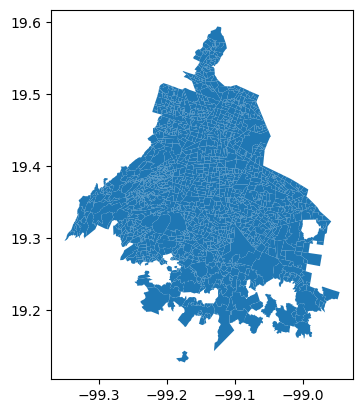

In [38]:
# plot it
gdf_colonias.plot()

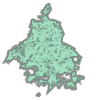

In [39]:
# join all the polygons into one big poligon
merged_polygon = gdf_colonias.unary_union
merged_polygon

In [40]:
# get all the states of mexico
gdf_states = gpd.read_file('../data/mexico_states')
gdf_states


,CODIGO,ESTADO,geometry
0,MX02,Baja California,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,MX03,Baja California Sur,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,MX18,Nayarit,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,MX14,Jalisco,"POLYGON ((-101.52490 21.85664, -101.58830 21.7..."
4,MX01,Aguascalientes,"POLYGON ((-101.84620 22.01176, -101.96530 21.8..."
5,MX11,Guanajuato,"POLYGON ((-100.28030 20.20451, -100.34860 20.0..."
6,MX22,Querétaro,"POLYGON ((-100.12280 19.93804, -100.18250 20.0..."
7,MX13,Hidalgo,"POLYGON ((-98.65941 19.58540, -98.65556 19.595..."
8,MX16,Michoacán,"POLYGON ((-103.47960 18.96722, -103.34830 18.9..."
9,MX15,México,"POLYGON ((-98.62798 19.47576, -98.66612 19.405..."


<Axes: >

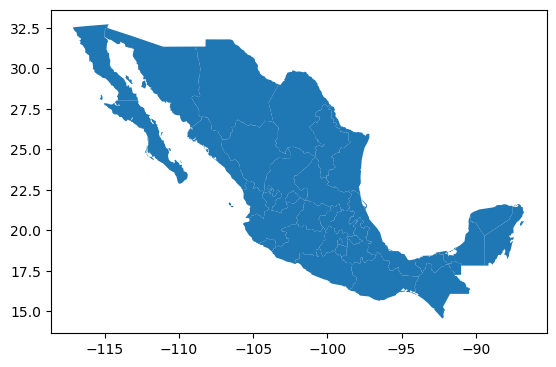

In [41]:
gdf_states.plot()

<Axes: >

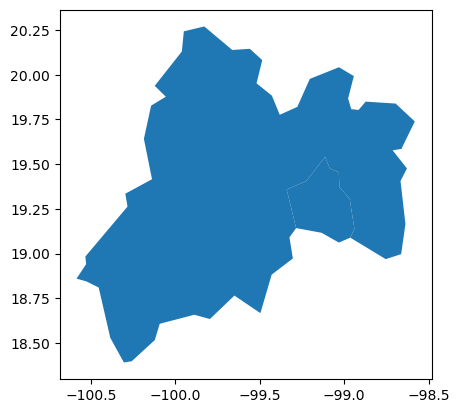

In [42]:
# get cdmx and mexico state
gdf_mex = gdf_states[gdf_states['CODIGO'].isin(['MX09', 'MX15'])]
gdf_mex.plot()

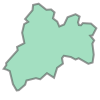

In [43]:
# join poligons
merged_polygon_mex = gdf_mex.unary_union
merged_polygon_mex

In [44]:
# filter
gdf_fitpass_r_mexico = gdf_fitpass_r[gdf_fitpass_r.within(merged_polygon_mex)]


<Axes: >

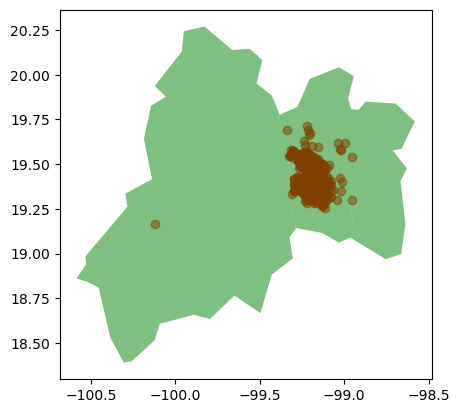

In [45]:
# add merged_polygon_mex to the plot
ax = gdf_fitpass_r_mexico.plot(color='red', alpha=0.5)
gdf_mex.plot(ax=ax, color='green', alpha=0.5)


<Axes: >

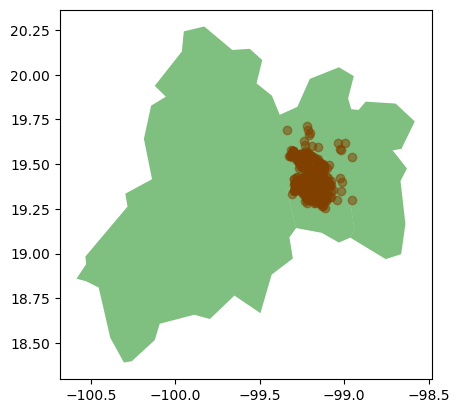

In [46]:
# get rid of the only outlier
gdf_fitpass_r_mexico = gdf_fitpass_r_mexico[gdf_fitpass_r_mexico['longitude'] > -99.5]

# plot
ax = gdf_fitpass_r_mexico.plot(color='red', alpha=0.5)
gdf_mex.plot(ax=ax, color='green', alpha=0.5)

In [121]:
# change crs
gdf_fitpass_mexico = gdf_fitpass_r_mexico.to_crs("EPSG:6372").copy()
gdf_fitpass_mexico

,gym_id,gym_name,pro_status,virtual_status,class_minutes,notes,latitude,longitude,address,barre,...,mma,pilates,pool,running,sports,virtual_class,wellness,yoga,ranking,geometry
0,3913,21159 Fit Movement,0,0,45,Centro de entrenamiento Funcional en HIIT. Som...,19.409432,-99.162129,"Av. Monterrey 271, esquina calle aguascalientes",0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.645175,POINT (2797185.358 826440.601)
1,4356,321 Move!,0,0,None,Movimiento y espacio virtual y presencial de F...,19.359657,-99.202687,"Pasaje Las Águilas, Calzada de las Águilas 321...",1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.850974,POINT (2793045.771 820864.041)
3,5576,3 Are Legend,0,0,None,Entrenamiento Funcional y box.,19.539159,-99.182145,Jesus Reyes Heroles 112,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.745202,POINT (2794808.235 840714.337)
4,3735,40º Grados Bikram Yoga,0,0,None,Estudio de Bikram Yoga y más en Zona Esmeralda,19.552389,-99.270923,Av. Adolfo Ruiz Cortines 247,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.874878,POINT (2785493.505 841994.524)
5,5694,60 Mind Fitness,0,0,None,Somos un estudio de entrenamiento de fuerza y ...,19.401965,-99.155869,Obrero Mundial 410 piso 6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.713634,POINT (2797857.171 825629.562)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,17,Zonadanza: Ballet Studio & Art,0,0,None,Escuela formativa con más de 13 años en el mer...,19.390768,-99.291066,Avenida Jesus del Monte # 17 Piso 2,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.853126,POINT (2783723.470 824119.766)
859,1623,Zuda Lilas,1,0,None,Wellness and Fitness Studio.,19.388010,-99.247764,Calle Paseo de Las Lilas 92,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.749351,POINT (2788264.046 823901.744)
860,3976,Zuda Prado Norte,1,0,None,Estudio de Wellness que integra tres estudios ...,19.427231,-99.211101,"Prado Norte 420, Piso 3",1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.562247,POINT (2792019.402 828304.207)
861,3101,Zuda Virtual,0,1,None,Wellness and Fitness Studio.,19.405721,-99.252566,Paseo de las Lilas 92 - Plaza Lilas piso 1,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.713526,POINT (2787723.708 825846.655)


## 0.2: User payload


In [147]:
user_info = {
    # user info
    "name": "roman",
    # location
    "location": {
        "longitude": -99.189679019841,
        "latitude": 19.356426878195325, 
    },
    # user preferences
    "preferences": {
        "love_activities": ["yoga", "pilates", "gym"],
        "hate_activities": ["dance", "running", "sports"],
    },
    # constraints
    "is_pro": 1,
    "max_allowed_classes_per_class": 4,
    "num_classes_per_month": 20,
}



In [124]:
# transform user location to epsg:6372
def get_tuples_points(point):
    return np.asarray([(point['longitude'], point['latitude'])])

def transform_points(points, from_epsg='epsg:4326', to_epsg='epsg:6372'):
    # create a geodataframe
    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            x=points[:, 0],
            y=points[:, 1]
        ),
        crs=from_epsg
    )
    # transform to epsg:6372
    gdf = gdf.to_crs(to_epsg)
    # return the points
    return np.array(gdf.geometry.apply(lambda x: (x.x, x.y)).tolist()) # maybe there is a more efficient weay

In [125]:
# get user location in meters
user_location = transform_points(get_tuples_points(user_info['location']))

# get distance from location to all gyms
gdf_fitpass_mexico['distance'] = gdf_fitpass_mexico.geometry.apply(lambda x: x.distance(Point(user_location[0]))/1000) # in km

# normalize distance
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

gdf_fitpass_mexico['distance_norm'] = normalize(gdf_fitpass_mexico['distance'])
gdf_fitpass_mexico

,gym_id,gym_name,pro_status,virtual_status,class_minutes,notes,latitude,longitude,address,barre,...,pool,running,sports,virtual_class,wellness,yoga,ranking,geometry,distance,distance_norm
0,3913,21159 Fit Movement,0,0,45,Centro de entrenamiento Funcional en HIIT. Som...,19.409432,-99.162129,"Av. Monterrey 271, esquina calle aguascalientes",0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.645175,POINT (2797185.358 826440.601),6.523714,0.161231
1,4356,321 Move!,0,0,None,Movimiento y espacio virtual y presencial de F...,19.359657,-99.202687,"Pasaje Las Águilas, Calzada de las Águilas 321...",1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.850974,POINT (2793045.771 820864.041),1.408685,0.033876
3,5576,3 Are Legend,0,0,None,Entrenamiento Funcional y box.,19.539159,-99.182145,Jesus Reyes Heroles 112,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.745202,POINT (2794808.235 840714.337),20.183964,0.501347
4,3735,40º Grados Bikram Yoga,0,0,None,Estudio de Bikram Yoga y más en Zona Esmeralda,19.552389,-99.270923,Av. Adolfo Ruiz Cortines 247,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.874878,POINT (2785493.505 841994.524),23.240997,0.577461
5,5694,60 Mind Fitness,0,0,None,Somos un estudio de entrenamiento de fuerza y ...,19.401965,-99.155869,Obrero Mundial 410 piso 6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.713634,POINT (2797857.171 825629.562),6.148921,0.151899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,17,Zonadanza: Ballet Studio & Art,0,0,None,Escuela formativa con más de 13 años en el mer...,19.390768,-99.291066,Avenida Jesus del Monte # 17 Piso 2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.853126,POINT (2783723.470 824119.766),11.277031,0.279580
859,1623,Zuda Lilas,1,0,None,Wellness and Fitness Studio.,19.388010,-99.247764,Calle Paseo de Las Lilas 92,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.749351,POINT (2788264.046 823901.744),7.012719,0.173406
860,3976,Zuda Prado Norte,1,0,None,Estudio de Wellness que integra tres estudios ...,19.427231,-99.211101,"Prado Norte 420, Piso 3",1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.562247,POINT (2792019.402 828304.207),8.131011,0.201250
861,3101,Zuda Virtual,0,1,None,Wellness and Fitness Studio.,19.405721,-99.252566,Paseo de las Lilas 92 - Plaza Lilas piso 1,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.713526,POINT (2787723.708 825846.655),8.543976,0.211532


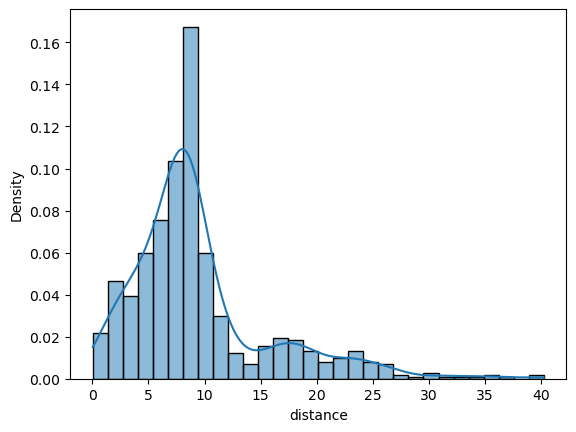

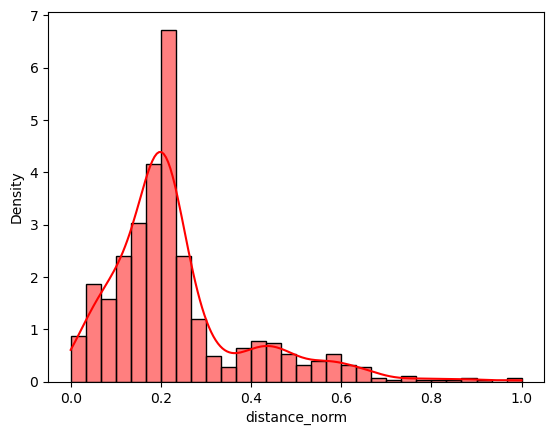

In [126]:
# plot histogram and density of distances
sns.histplot(data=gdf_fitpass_mexico, x='distance', stat='density', bins=30, kde=True)
plt.show()
sns.histplot(data=gdf_fitpass_mexico, x='distance_norm', stat='density', bins=30, kde=True, color='red')
plt.show()

In [127]:
def exp_dist(x, alpha=1):
    return (np.exp(alpha*x)-1)/(np.exp(alpha)-1)

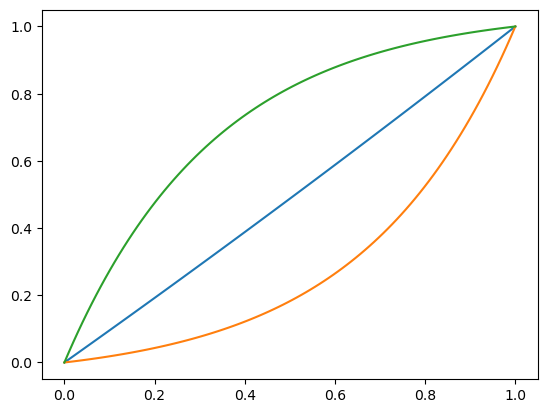

In [128]:
# plot exp_dist
plt.plot(np.linspace(0, 1, 100), exp_dist(np.linspace(0, 1, 100), alpha=0.1))
plt.plot(np.linspace(0, 1, 100), exp_dist(np.linspace(0, 1, 100), alpha=3))
plt.plot(np.linspace(0, 1, 100), exp_dist(np.linspace(0, 1, 100), alpha=-3))

<Axes: xlabel='distance_exp', ylabel='Density'>

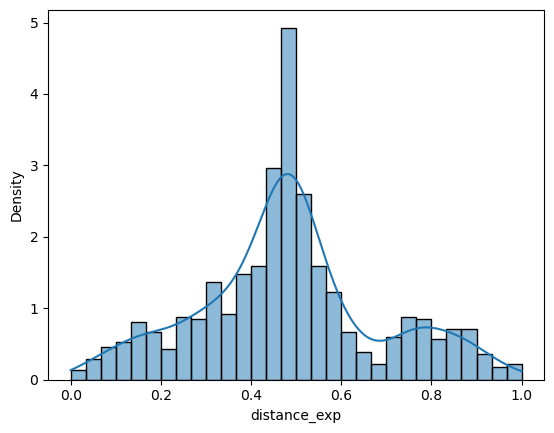

In [129]:
# penalize exponentialy the distance
gdf_fitpass_mexico['distance_exp'] = exp_dist(gdf_fitpass_mexico['distance_norm'], alpha=-3)

# plot histogram and density of distances
sns.histplot(data=gdf_fitpass_mexico, x='distance_exp', stat='density', bins=30, kde=True)

### ranking & preferences

In [130]:
# pass wide to long format
gdf_fitpass_mexico_long = (
    gdf_fitpass_mexico.copy()
    .melt(
        id_vars=['gym_id'],
        value_vars=[
            'barre', 'box', 'crossfit', 'cycling', 'dance',
            'ems', 'functional', 'gym', 'hiit', 'mma', 'pilates',
            'pool', 'running', 'sports', 'wellness', 'yoga'
            ],
        var_name='activity',
    )
    .query('value >= 1')
    # compress all the activities into a list
    .groupby('gym_id', as_index=False)['activity'].apply(list)
)
gdf_fitpass_mexico_long

# join to the original df
gdf_fitpass_mexico = gdf_fitpass_mexico.merge(gdf_fitpass_mexico_long, on='gym_id', how='left')
gdf_fitpass_mexico


,gym_id,gym_name,pro_status,virtual_status,class_minutes,notes,latitude,longitude,address,barre,...,sports,virtual_class,wellness,yoga,ranking,geometry,distance,distance_norm,distance_exp,activity
0,3913,21159 Fit Movement,0,0,45,Centro de entrenamiento Funcional en HIIT. Som...,19.409432,-99.162129,"Av. Monterrey 271, esquina calle aguascalientes",0.0,...,0.0,0.0,1.0,0.0,0.645175,POINT (2797185.358 826440.601),6.523714,0.161231,0.403591,"[crossfit, hiit, mma, wellness]"
1,4356,321 Move!,0,0,None,Movimiento y espacio virtual y presencial de F...,19.359657,-99.202687,"Pasaje Las Águilas, Calzada de las Águilas 321...",1.0,...,1.0,0.0,0.0,0.0,0.850974,POINT (2793045.771 820864.041),1.408685,0.033876,0.101697,"[barre, box, dance, functional, hiit, mma, pil..."
2,5576,3 Are Legend,0,0,None,Entrenamiento Funcional y box.,19.539159,-99.182145,Jesus Reyes Heroles 112,0.0,...,0.0,0.0,0.0,0.0,0.745202,POINT (2794808.235 840714.337),20.183964,0.501347,0.818521,"[box, functional]"
3,3735,40º Grados Bikram Yoga,0,0,None,Estudio de Bikram Yoga y más en Zona Esmeralda,19.552389,-99.270923,Av. Adolfo Ruiz Cortines 247,0.0,...,0.0,0.0,0.0,1.0,0.874878,POINT (2785493.505 841994.524),23.240997,0.577461,0.866267,"[hiit, yoga]"
4,5694,60 Mind Fitness,0,0,None,Somos un estudio de entrenamiento de fuerza y ...,19.401965,-99.155869,Obrero Mundial 410 piso 6,0.0,...,0.0,0.0,0.0,0.0,0.713634,POINT (2797857.171 825629.562),6.148921,0.151899,0.385171,"[functional, hiit]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,17,Zonadanza: Ballet Studio & Art,0,0,None,Escuela formativa con más de 13 años en el mer...,19.390768,-99.291066,Avenida Jesus del Monte # 17 Piso 2,0.0,...,0.0,0.0,0.0,1.0,0.853126,POINT (2783723.470 824119.766),11.277031,0.279580,0.597492,"[dance, functional, mma, pilates, yoga]"
848,1623,Zuda Lilas,1,0,None,Wellness and Fitness Studio.,19.388010,-99.247764,Calle Paseo de Las Lilas 92,1.0,...,0.0,0.0,1.0,1.0,0.749351,POINT (2788264.046 823901.744),7.012719,0.173406,0.426862,"[barre, box, crossfit, cycling, dance, functio..."
849,3976,Zuda Prado Norte,1,0,None,Estudio de Wellness que integra tres estudios ...,19.427231,-99.211101,"Prado Norte 420, Piso 3",1.0,...,0.0,0.0,0.0,1.0,0.562247,POINT (2792019.402 828304.207),8.131011,0.201250,0.476990,"[barre, crossfit, cycling, dance, functional, ..."
850,3101,Zuda Virtual,0,1,None,Wellness and Fitness Studio.,19.405721,-99.252566,Paseo de las Lilas 92 - Plaza Lilas piso 1,1.0,...,0.0,1.0,0.0,1.0,0.713526,POINT (2787723.708 825846.655),8.543976,0.211532,0.494468,"[barre, crossfit, cycling, functional, hiit, p..."


In [132]:
# num of gyms without activities
gdf_fitpass_mexico['activity'].isna().sum()

6

In [133]:
# drop them
gdf_fitpass_mexico = gdf_fitpass_mexico.dropna(subset=['activity'])

In [140]:
# multiply preference by ranking
# if the activity is in love multiply by 2 if the activity is in hate multiply by 0 else multiply by 1
gdf_fitpass_mexico['preference'] = np.select(
    [
        gdf_fitpass_mexico['activity'].apply(lambda x: any([i in user_info['preferences']['love_activities'] for i in x])),
        gdf_fitpass_mexico['activity'].apply(lambda x: any([i in user_info['preferences']['hate_activities'] for i in x])),
    ],
    [
        2,
        0,
    ],
    default=1
)

gdf_fitpass_mexico.preference.value_counts()

/Users/ravj/opt/anaconda3/envs/academic-spyder-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


preference
2    501
1    249
0     96
Name: count, dtype: int64

In [141]:
# multiply preference by ranking
gdf_fitpass_mexico['preference_distance'] = normalize(gdf_fitpass_mexico['preference'] * gdf_fitpass_mexico['distance'])

/Users/ravj/opt/anaconda3/envs/academic-spyder-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: xlabel='preference_distance', ylabel='Density'>

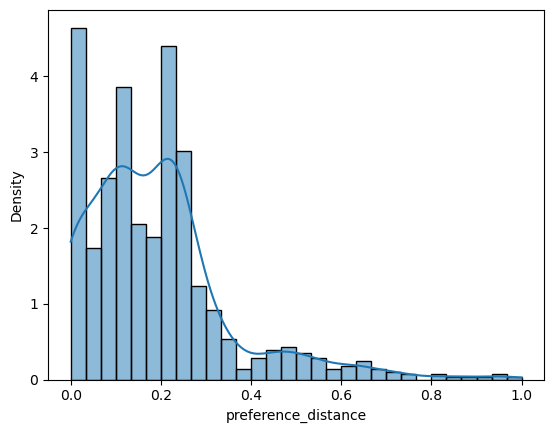

In [142]:
# look distribution of preference_distance
sns.histplot(data=gdf_fitpass_mexico, x='preference_distance', stat='density', bins=30, kde=True)

### subset for Pro or Not Pro

In [149]:
# subset gyms by pro or normal plan
gdf_fitpass_mexico = gdf_fitpass_mexico[gdf_fitpass_mexico['pro_status'] <= user_info['is_pro']]

In [152]:
gdf_fitpass_mexico = gdf_fitpass_mexico.sort_values(by='gym_id', ignore_index=True)
gdf_fitpass_mexico

,gym_id,gym_name,pro_status,virtual_status,class_minutes,notes,latitude,longitude,address,barre,...,wellness,yoga,ranking,geometry,distance,distance_norm,distance_exp,activity,preference,preference_distance
0,1006,UFC Gym Artz Pedregal,1,0,None,"Gimnasio de pesas, entrenamiento funcional, cl...",19.313467,-99.219074,"Plaza Artz, Nivel 2, Torre 3. Local Ufc Gym. B...",1.0,...,0.0,1.0,0.744503,POINT (2791428.148 815732.883),5.654704,0.139594,0.360080,"[barre, box, cycling, dance, functional, gym, ...",2,0.153820
1,1009,Perfect 10,1,0,None,Body Sculpting,19.430090,-99.195919,Alejandro Dumas 71-Altos,0.0,...,1.0,0.0,0.880124,POINT (2793602.704 828650.704),8.157081,0.201899,0.478109,"[ems, wellness]",1,0.110945
2,1024,Iron Core by CRTR,0,0,None,Somos un gimnasio diferente con el objetivo de...,19.375681,-99.166465,Miguel Laurent 510 (dentro de la plaza),0.0,...,0.0,0.0,0.756290,POINT (2796804.944 822706.949),3.229747,0.079217,0.222605,"[crossfit, functional, hiit]",1,0.043928
3,1031,Polly’s Place,1,0,None,Clínica de Belleza. Uso de cubrebocas en todo ...,19.423050,-99.223378,Paseo de las palmas 1275 (entre Monte Chimbora...,0.0,...,1.0,0.0,0.824619,POINT (2790742.999 827817.874),8.157063,0.201898,0.478109,[wellness],1,0.110944
4,1036,Urban Athlete / Balan-C,1,0,None,Studio de EMS. Nuestro personal capacitado con...,19.402281,-99.269957,Centro Comercial Interlomas Locales D2-D3. Ent...,0.0,...,1.0,1.0,0.803082,POINT (2785909.892 825432.246),9.814925,0.243176,0.544997,"[ems, functional, wellness, yoga]",2,0.266986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,967,Sáasil Fit Slim Condesa,1,0,None,Spa Sáasil es una clínica de belleza dedicada ...,19.413469,-99.172406,Av Tamaulipas 29 Pb,0.0,...,0.0,0.0,0.599161,POINT (2796100.493 826864.848),6.551108,0.161913,0.404917,[functional],1,0.089102
842,969,Sáasil Fit Preso Insurgentes,1,0,None,spa saasil es una clínica de belleza dedicada ...,19.363595,-99.182566,TORRE MURAL INSURGENTES SUR 1605 1ER PISO LOCA...,0.0,...,1.0,0.0,0.436858,POINT (2795144.832 821339.905),1.086917,0.025864,0.078571,[wellness],1,0.014783
843,978,Jazzercise Del Valle,0,0,None,Nuestro original workout de baile con ejercici...,19.372302,-99.173884,Felix Cuevas 407 primer piso,1.0,...,0.0,1.0,0.771457,POINT (2796035.274 822318.710),2.410148,0.058810,0.170218,"[barre, dance, functional, hiit, pilates, yoga]",2,0.065561
844,984,Punta Sala de Esgrima,1,0,None,Club de esgrima que busca contribuir en la for...,19.406075,-99.275945,"Calle Palma Criolla 14, Plaza Altika",0.0,...,0.0,0.0,0.801751,POINT (2785274.907 825839.018),10.568246,0.261932,0.572760,[sports],0,0.000000


## 0.3: Fixed data

In [153]:
N_CLASSES = gdf_fitpass_r_mexico['gym_id'].nunique()
N_ACTIVITIES = 16
M_CLASS_CAN_ATTEND = 4
LIST_ACTIVITIES = [
    'barre', 'box', 'crossfit', 'cycling', 'dance',
    'ems', 'functional', 'gym', 'hiit', 'mma', 'pilates',
    'pool', 'running', 'sports', 'wellness', 'yoga'
] # note: should do it with the dataframe

NOTE: i have the issue that some gyms are "multi-activity" 

# Part 1: create class for each gym




In [156]:
gdf_fitpass_mexico.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gym_id               846 non-null    object  
 1   gym_name             846 non-null    object  
 2   pro_status           846 non-null    int64   
 3   virtual_status       846 non-null    int64   
 4   class_minutes        58 non-null     object  
 5   notes                846 non-null    object  
 6   latitude             846 non-null    float64 
 7   longitude            846 non-null    float64 
 8   address              846 non-null    object  
 9   barre                846 non-null    float64 
 10  box                  846 non-null    float64 
 11  crossfit             846 non-null    float64 
 12  cycling              846 non-null    float64 
 13  dance                846 non-null    float64 
 14  ems                  846 non-null    float64 
 15  functional     

In [323]:
# gym class
class Gym:
    def __init__(self, dict_gym, variable):
        # pulp variable for optimization
        self.pulp_var = variable

        # self vars
        self.id = dict_gym['gym_id']
        self.name = dict_gym['gym_name']
        self.point = dict_gym['geometry']
        
        # values for the optimization
        self.distance = dict_gym['distance_exp']
        self.ranking = dict_gym['preference_distance']
        # values for constraints
        self.activities = dict_gym['activity']

    def __str__(self) -> str:
        # lower case name
        # TODO: better representation
        tidy_name = self.name.lower()
        s = f"id: {self.id} - {tidy_name}: times {self.pulp_var.value()}"
        return s
    
    def compare_activity(self, activity):
        return activity in self.activities
    
    def get_distance(self):
        return self.distance * self.pulp_var
    
    def get_preference(self):
        return self.ranking * self.pulp_var
    
    def get_variable(self):
        return self.pulp_var
    
    def __lt__(self, other):
        return self.pulp_var.value() < other
    
    def __le__(self, other):
        return self.pulp_var.value() <= other
    
    def __ge__(self, other):
        return self.pulp_var.value() >= other
    
    def __gt__(self, other):
        return self.pulp_var.value() > other
    
    def __eq__(self, other):
        return self.pulp_var.value() == other

    

In [324]:
# save all the Gym objects to a dictionary 
gym_dict = {}

# create a list of gym objects
for i, row in gdf_fitpass_mexico.iterrows():
    # to Gym object
    gym_fitpass = Gym(
        row, 
        plp.LpVariable(
            name=f"gym_{row['gym_id']}", 
            lowBound=0, upBound=user_info["max_allowed_classes_per_class"],
            cat='Integer'
            )
        )
    # save it
    gym_dict[row['gym_id']] = gym_fitpass

In [325]:
print(gym_dict['111'])

id: 111 - sersana polanco: times None


In [326]:
len(gym_dict)

846

## Restriction of classes within activities



In [327]:
# auxiliar variable for classes with the same activity
activities_dict = {}

# create a list of auxiliar variables
for activity in LIST_ACTIVITIES:
    # pulp variable
    activities_dict[activity] = plp.LpVariable(
        name=f"activity_{activity}",
        lowBound=0, upBound=1, cat='Binary'
    )


In [328]:
activities_dict

{'barre': activity_barre,
 'box': activity_box,
 'crossfit': activity_crossfit,
 'cycling': activity_cycling,
 'dance': activity_dance,
 'ems': activity_ems,
 'functional': activity_functional,
 'gym': activity_gym,
 'hiit': activity_hiit,
 'mma': activity_mma,
 'pilates': activity_pilates,
 'pool': activity_pool,
 'running': activity_running,
 'sports': activity_sports,
 'wellness': activity_wellness,
 'yoga': activity_yoga}

## Aux variables for how many different classes the user will do

In [329]:
# auxiliar variable for number of classes in the same gym
n_classes_dict = {}

# create a list of auxiliar variables
for gym_id in gym_dict.keys():
    # pulp variable
    n_classes_dict[gym_id] = plp.LpVariable(
        name=f"classes_{gym_id}",
        lowBound=0, upBound=1, cat='Binary'
    )

In [330]:
n_classes_dict

{'1006': classes_1006,
 '1009': classes_1009,
 '1024': classes_1024,
 '1031': classes_1031,
 '1036': classes_1036,
 '1051': classes_1051,
 '1061': classes_1061,
 '1064': classes_1064,
 '1066': classes_1066,
 '1067': classes_1067,
 '1068': classes_1068,
 '1089': classes_1089,
 '111': classes_111,
 '1112': classes_1112,
 '1113': classes_1113,
 '1114': classes_1114,
 '1116': classes_1116,
 '1126': classes_1126,
 '113': classes_113,
 '1138': classes_1138,
 '114': classes_114,
 '116': classes_116,
 '1167': classes_1167,
 '1170': classes_1170,
 '1171': classes_1171,
 '1182': classes_1182,
 '1192': classes_1192,
 '1194': classes_1194,
 '1207': classes_1207,
 '1208': classes_1208,
 '1214': classes_1214,
 '1221': classes_1221,
 '1286': classes_1286,
 '1298': classes_1298,
 '131': classes_131,
 '1323': classes_1323,
 '1331': classes_1331,
 '137': classes_137,
 '1375': classes_1375,
 '1378': classes_1378,
 '1380': classes_1380,
 '1384': classes_1384,
 '1385': classes_1385,
 '1386': classes_1386,


# 2: Create problem: 

## 2.1: Objective function

In [331]:
# define weights
w_distance = 0.45
w_preference = 0.4
w_activity = 0.05
w_n_classes = 0.1

In [332]:
# init problem
prob = plp.LpProblem("Fitpass", plp.LpMinimize)

# add distance to objective function
f_distance = plp.lpSum([gym.get_distance() for gym in gym_dict.values()])
# add preference to objective function
f_preference = plp.lpSum([gym.get_preference() for gym in gym_dict.values()])
# add diversity of activities
f_activity = plp.lpSum((activities_dict.values()))
# add diversity of classes
f_n_classes = plp.lpSum(list(n_classes_dict.values()))

# add objective function
prob += (
    w_distance*f_distance - w_preference*f_preference 
    - w_activity*f_activity - w_n_classes*f_n_classes
    ,
    "objective function"
    )
# print objective function
print(prob.objective)


-0.05*activity_barre - 0.05*activity_box - 0.05*activity_crossfit - 0.05*activity_cycling - 0.05*activity_dance - 0.05*activity_ems - 0.05*activity_functional - 0.05*activity_gym - 0.05*activity_hiit - 0.05*activity_mma - 0.05*activity_pilates - 0.05*activity_pool - 0.05*activity_running - 0.05*activity_sports - 0.05*activity_wellness - 0.05*activity_yoga - 0.1*classes_1006 - 0.1*classes_1009 - 0.1*classes_1024 - 0.1*classes_1031 - 0.1*classes_1036 - 0.1*classes_1051 - 0.1*classes_1061 - 0.1*classes_1064 - 0.1*classes_1066 - 0.1*classes_1067 - 0.1*classes_1068 - 0.1*classes_1089 - 0.1*classes_111 - 0.1*classes_1112 - 0.1*classes_1113 - 0.1*classes_1114 - 0.1*classes_1116 - 0.1*classes_1126 - 0.1*classes_113 - 0.1*classes_1138 - 0.1*classes_114 - 0.1*classes_116 - 0.1*classes_1167 - 0.1*classes_1170 - 0.1*classes_1171 - 0.1*classes_1182 - 0.1*classes_1192 - 0.1*classes_1194 - 0.1*classes_1207 - 0.1*classes_1208 - 0.1*classes_1214 - 0.1*classes_1221 - 0.1*classes_1286 - 0.1*classes_1298 

## 2.2: Constraints 


In [333]:
# constraint of max classes per gym (already defined in the pulp variable bounds)

# constraint of max classes per month
prob += (
    plp.lpSum([gym.get_variable() for gym in gym_dict.values()]) == user_info['num_classes_per_month'],
    "classes per month"
)


# auxiliar variable constraint for activities
for k, v in activities_dict.items():
    # get all the gyms with the activity
    gyms_with_activity = [gym for gym in gym_dict.values() if gym.compare_activity(k)]
    # add constraint
    prob += (
        v <= plp.lpSum([gym.get_variable() for gym in gyms_with_activity]),
        f"activity_{k}"
    )

# auxiliar variable constraint for number of classes in the same gym
for k, v in n_classes_dict.items():
    # get all the gyms with the activity
    gym = gym_dict[k]
    # add constraint
    prob += (
        v <= gym.get_variable(),
        f"classes_at_gym{k}"
    )

In [334]:
# print the problem
print(prob)

Fitpass:
MINIMIZE
-0.05*activity_barre + -0.05*activity_box + -0.05*activity_crossfit + -0.05*activity_cycling + -0.05*activity_dance + -0.05*activity_ems + -0.05*activity_functional + -0.05*activity_gym + -0.05*activity_hiit + -0.05*activity_mma + -0.05*activity_pilates + -0.05*activity_pool + -0.05*activity_running + -0.05*activity_sports + -0.05*activity_wellness + -0.05*activity_yoga + -0.1*classes_1006 + -0.1*classes_1009 + -0.1*classes_1024 + -0.1*classes_1031 + -0.1*classes_1036 + -0.1*classes_1051 + -0.1*classes_1061 + -0.1*classes_1064 + -0.1*classes_1066 + -0.1*classes_1067 + -0.1*classes_1068 + -0.1*classes_1089 + -0.1*classes_111 + -0.1*classes_1112 + -0.1*classes_1113 + -0.1*classes_1114 + -0.1*classes_1116 + -0.1*classes_1126 + -0.1*classes_113 + -0.1*classes_1138 + -0.1*classes_114 + -0.1*classes_116 + -0.1*classes_1167 + -0.1*classes_1170 + -0.1*classes_1171 + -0.1*classes_1182 + -0.1*classes_1192 + -0.1*classes_1194 + -0.1*classes_1207 + -0.1*classes_1208 + -0.1*classe

## 2.3: Solve the problem

In [335]:
# solve the problem
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ravj/opt/anaconda3/envs/academic-spyder-env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/7e5f2562f23f4d2b8212cec9b1e32b17-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/7e5f2562f23f4d2b8212cec9b1e32b17-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 868 COLUMNS
At line 10727 RHS
At line 11591 BOUNDS
At line 13300 ENDATA
Problem MODEL has 863 rows, 1708 columns and 4734 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -2.45212 - 0.00 seconds
Cgl0004I processed model has 863 rows, 1708 columns (1708 integer (862 of which binary)) and 4734 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -2.45212
Cbc0038I Cleaned solution

1

In [336]:
plp.LpStatus[prob.status]

'Optimal'

## 2.4 Get variables of the solution


In [337]:
# get variables of the solution
for v in prob.variables():
    print(v.name, "=", v.varValue)
    

activity_barre = 1.0
activity_box = 1.0
activity_crossfit = 1.0
activity_cycling = 1.0
activity_dance = 1.0
activity_ems = 1.0
activity_functional = 1.0
activity_gym = 1.0
activity_hiit = 1.0
activity_mma = 1.0
activity_pilates = 1.0
activity_pool = 1.0
activity_running = 1.0
activity_sports = 1.0
activity_wellness = 1.0
activity_yoga = 1.0
classes_1006 = 0.0
classes_1009 = 0.0
classes_1024 = 0.0
classes_1031 = 0.0
classes_1036 = 0.0
classes_1051 = 1.0
classes_1061 = 0.0
classes_1064 = 0.0
classes_1066 = 1.0
classes_1067 = 0.0
classes_1068 = 0.0
classes_1089 = 0.0
classes_111 = 0.0
classes_1112 = 0.0
classes_1113 = 0.0
classes_1114 = 0.0
classes_1116 = 0.0
classes_1126 = 0.0
classes_113 = 0.0
classes_1138 = 0.0
classes_114 = 0.0
classes_116 = 1.0
classes_1167 = 0.0
classes_1170 = 0.0
classes_1171 = 0.0
classes_1182 = 0.0
classes_1192 = 0.0
classes_1194 = 0.0
classes_1207 = 0.0
classes_1208 = 0.0
classes_1214 = 0.0
classes_1221 = 0.0
classes_1286 = 0.0
classes_1298 = 0.0
classes_131 = 0

In [338]:
# print one gym
aux = gym_dict['5700']
print(aux)

id: 5700 - we • workout + enjoy: times 1.0


In [339]:
aux == 1

True

In [341]:
# get all the gyms with classes
gym_dict_with_classes = [gym for gym in gym_dict.values() if gym > 0]

# print all the gyms with classes
for gym in gym_dict_with_classes:
    print(gym)
    

id: 1051 - el t3mplo altavista outdoors: times 1.0
id: 1066 - sport city insurgentes: times 1.0
id: 116 - soulcore altavista: times 1.0
id: 1900 - smart fit torre diamante: times 1.0
id: 2112 - santuario studio san ángel: times 1.0
id: 2509 - team force fitness studio: times 1.0
id: 2616 - sports world barranca: times 1.0
id: 2634 - sports world manacar: times 1.0
id: 2648 - sports world san ángel: times 1.0
id: 3182 - uddiyana yoga virtual: times 1.0
id: 4283 - smart fit pabellón altavista: times 1.0
id: 4315 - wild fitness: times 1.0
id: 4675 - arhat center yoga y meditacion: times 1.0
id: 5221 - smartbeat san angel: times 1.0
id: 5358 - rila studio: times 1.0
id: 540 - miura boxing: times 1.0
id: 5520 - sima wellness center: times 1.0
id: 5700 - we • workout + enjoy: times 1.0
id: 5713 - shankara yoga: times 1.0
id: 969 - sáasil fit preso insurgentes: times 1.0


note: in the print of the gym add also the activities involved

In [345]:
# get all the activities with classes
activities_with_classes = [activity for activity in activities_dict.values() if activity.value() > 0]

# print all the activities with classes
for activity in activities_with_classes:
    print(activity.name)

activity_barre
activity_box
activity_crossfit
activity_cycling
activity_dance
activity_ems
activity_functional
activity_gym
activity_hiit
activity_mma
activity_pilates
activity_pool
activity_running
activity_sports
activity_wellness
activity_yoga


note: it is diversifying more than it should